In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
df_deaths = pd.read_csv('../data_set/time_series_covid19_deaths_global.csv')

In [4]:
df_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/27/21,7/28/21,7/29/21,7/30/21,7/31/21,8/1/21,8/2/21,8/3/21,8/4/21,8/5/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,6515,6577,6615,6677,6677,6677,6774,6804,6836,6864
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,2456,2457,2457,2457,2457,2457,2457,2457,2457,2457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,4112,4161,4189,4219,4254,4291,4329,4370,4404,4441
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,127,127,127,128,128,128,128,128,128,128
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,994,1000,1003,1008,1011,1016,1018,1022,1026,1032


In [5]:
df_deaths_country = df_deaths[df_confirmed["Country/Region"] == 'India']
df_deaths_country = pd.DataFrame(df_deaths_country[df_deaths_country.columns[4:]].sum(),
                                    columns=["confirmed"])
df_deaths_country.index = pd.to_datetime(df_deaths_country.index,format='%m/%d/%y')

df_deaths_country.head()

,confirmed
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0


<AxesSubplot:title={'center':'COVID confirmed cases'}>

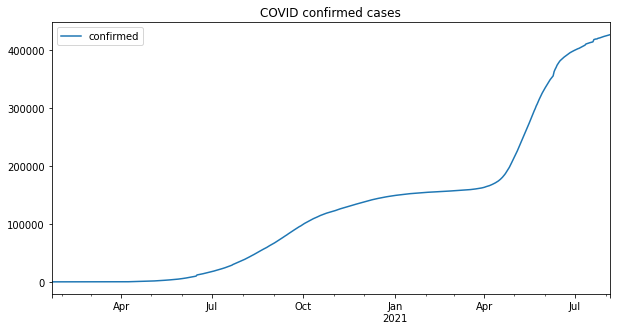

In [6]:
df_deaths_country.plot(figsize=(10,5),title="COVID confirmed cases")

In [7]:
x = len(df_deaths_country)- 14
train=df_deaths_country.iloc[:x]
test = df_deaths_country.iloc[x:]

In [8]:
scaler = MinMaxScaler()
scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [9]:
seq_size = 7 
n_features = 1 
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) 
print("Total number of samples in the generated data = ", len(train_generator)) 

x,y = train_generator[10] 
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test))
print("Total number of samples in the generated data = ", len(test_generator))

Total number of samples in the original training data =  548
Total number of samples in the generated data =  541
Total number of samples in the original training data =  14
Total number of samples in the generated data =  7


In [10]:
x,y = test_generator[0]

In [11]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 30, return_sequences = True, input_shape=(seq_size, n_features)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer nd some Dropout regularisation
regressor.add(LSTM(units = 45, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 60, return_sequences = True))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 30))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [12]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 7, 30)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 45)             13680     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 45)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 60)             25440     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                10920     
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [13]:
history = regressor.fit(train_generator, 
                              validation_data=test_generator, 
                              epochs=50, steps_per_epoch=10)

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.037 - 282s 30s/step - loss: 0.0372 - val_loss: 0.6633
Epoch 2/50
10/10 [==============================] - 6s 372ms/step - loss: 0.0240 - val_loss: 0.1219
Epoch 3/50
10/10 [==============================] - 0s 27ms/step - loss: 0.0369 - val_loss: 0.1971
Epoch 4/50
10/10 [==============================] - 0s 25ms/step - loss: 0.0390 - val_loss: 0.0029
Epoch 5/50
10/10 [==============================] - 0s 29ms/step - loss: 0.0135 - val_loss: 0.0495
Epoch 6/50
10/10 [==============================] - 0s 26ms/step - loss: 0.0016 - val_loss: 0.0086
Epoch 7/50
10/10 [==============================] - 0s 31ms/step - loss: 0.0053 - val_loss: 0.0426
Epoch 8/50
10/10 [==============================] - 0s 28ms/step - loss: 0.0058 - val_loss: 0.0295
Epoch 9/50
10/10 [==============================] - 0s 26ms/step - loss: 0.0023 - val_loss: 4.9238e-06
Epoch 10/50
10/10 [==============================] - 0s 26ms/step - loss: 8.484

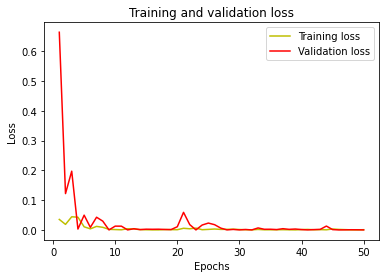

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
prediction_deaths = []

In [17]:
current_batch = train_scaled[-seq_size:]
current_batch = current_batch.reshape(1, seq_size, n_features)

future = 30
for i in range(len(test) + future):
    current_pred = regressor.predict(current_batch)[0]
    prediction_deaths.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

rescaled_prediction = scaler.inverse_transform(prediction_deaths)
time_series_array = test.index 
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

In [18]:
df_forecast = pd.DataFrame(columns=["actual_deaths","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_deaths"] = test["confirmed"]

<AxesSubplot:title={'center':'Predictions for next 30 days'}>

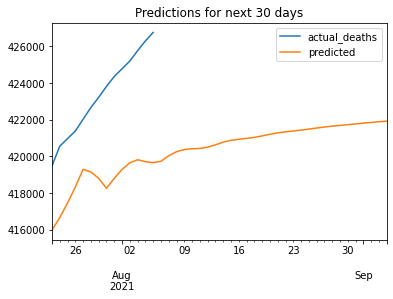

In [19]:
df_forecast.plot(title="Predictions for next 30 days")

In [20]:
df_forecast.to_csv('deaths_forecast.csv')